## Data Exploration Notebook

In [112]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from accel_utils import AccelUtils

In [113]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
# Some values that will remain constant throughout experiments
DATA_DIR = './user_data'
FILE_LIST = [f for f in os.listdir(DATA_DIR) if os.path.splitext(f)[1] == '.csv']
NUM_SUBJ = len(FILE_LIST)
print(f'Number of files/subjects: {NUM_SUBJ}')

# Some other constants that were hand-tuned to be used later
MAX_TIME_STEP = 0.035
RESAMPLE_TIME_STEP = 0.030
WINDOW_SIZE_SEC = 3.8
MAX_RESAMPLE_PTS = int(WINDOW_SIZE_SEC // RESAMPLE_TIME_STEP) - 3
print(f'Each sample will be {MAX_RESAMPLE_PTS} time steps')

Number of files/subjects: 22
Each sample will be 123 time steps


In [115]:
per_user_all_data = AccelUtils.read_all_user_data(DATA_DIR, NUM_SUBJ)
    

In [116]:
per_user_all_data[0].describe()

,t,x_acc,y_acc,z_acc,mag_acc
count,5069.00000,5069.000000,5069.000000,5069.000000,5069.000000
mean,76.81745,-3.554254,8.557989,-0.844095,10.072604
std,44.23811,2.486629,2.956517,2.913708,2.922008
min,0.00000,-9.343600,0.000000,-7.927000,2.956867
25%,38.57000,-5.284700,6.129200,-2.601500,7.851683
50%,76.82000,-3.486800,8.921300,-1.144100,9.881105
75%,115.01000,-2.179300,10.651000,-0.040861,12.184767
max,154.20000,10.951000,15.786000,12.599000,17.870653


## Let's look at the data
Bird's eye view of all 22 subjects' data.

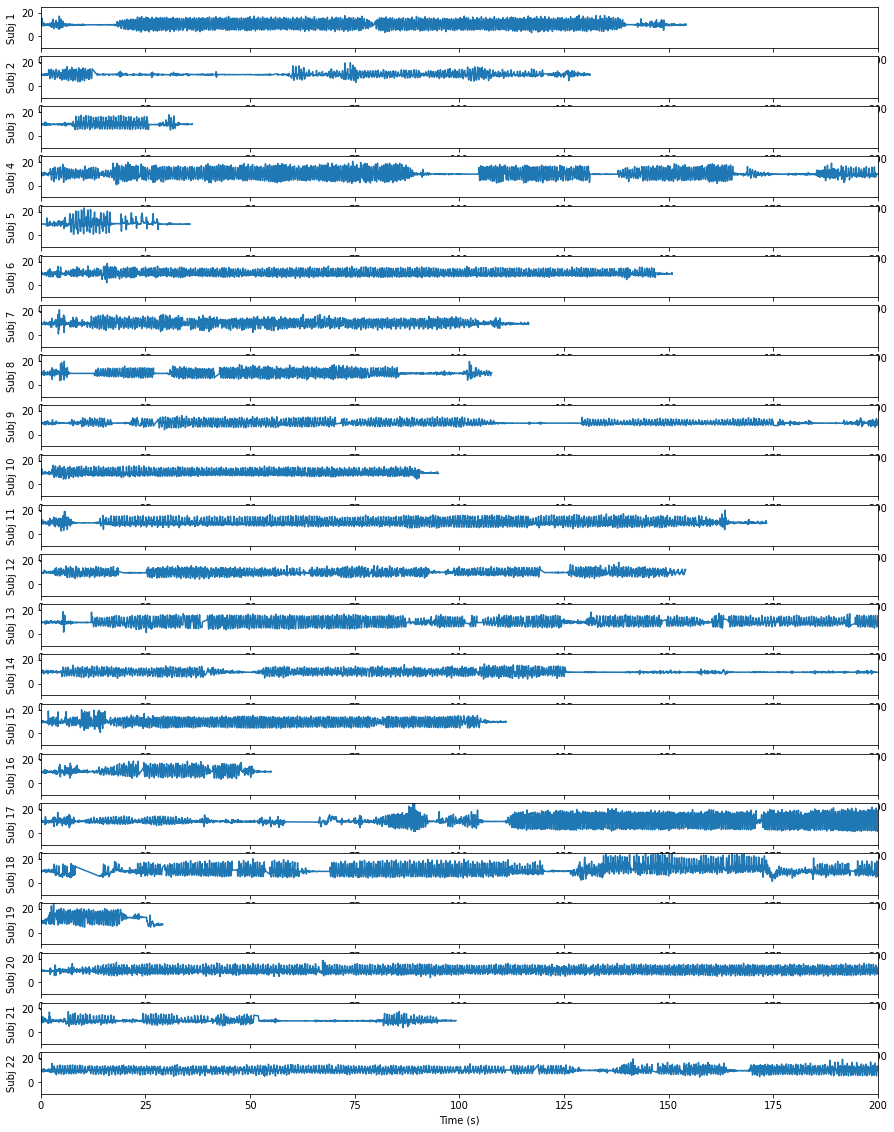

In [117]:
fig, axs = plt.subplots(NUM_SUBJ, 1, figsize=(15, 20))

for i in range(NUM_SUBJ):
    axs[i].plot(per_user_all_data[i]['t'], per_user_all_data[i]['mag_acc'])
    axs[i].set_xlim(0, 200)
    axs[i].set_ylim(-10, 25)
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel(f'Subj {i+1}')

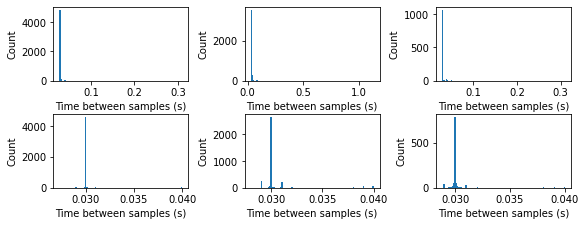

In [118]:
fig, axs = plt.subplots(2, 3, figsize=(8, 3))
for i in range(3):
    time_list = per_user_all_data[i]['t'].values
    diffs = time_list[1:] - time_list[:-1]
    axs[0][i].hist(diffs, bins=100)
    axs[0][i].set_xlabel('Time between samples (s)')
    axs[0][i].set_ylabel('Count')

    diffs_clipped = diffs[diffs <= 0.04]
    axs[1][i].hist(diffs_clipped, bins=100)
    axs[1][i].set_xlabel('Time between samples (s)')
    axs[1][i].set_ylabel('Count')
    
fig.tight_layout(pad=0.2)


## The Plan
We need to extract sections of each person's walking data that is "regular."  This means that it fits the following criteria:
1. Long enough to capture multiple full periods of oscillations
1. Signal is approximately stationary
2. Average absolute value around DC is above a given threshold
3. No large gaps in time

In the interest of time and to avoid diving too deep and making this a research project, let's estimate the criteria to use:
1. Use 2-second time slices/windows (approx 60 time steps)
2. Sub-divide each window into 3 partitions and check that their statistics are approximately the same (thus, stationary and consistent)
3. Avg oscillation exceeds threshold:  np.mean(abs(signal - avg)) > 2.0
3. All time steps are less than 0.035s

Then we'll have to resample the data at a constant interval for both intra-sample consistency as well as comparing different samples.

## Sampling Strategy
Use the above criteria to extract labeled samples from all subjects.  Some subjects have shorter total time, and may have less samples.  Samples for training can be overlapping, though testing samples much have zero overlap with other testing or training samples


Subject 17 (index 16) has the most diverse data.  Test out the above on it (these results are after hand-tuning the thresholds):

Show which time-windows are considered valid by the specified criteria


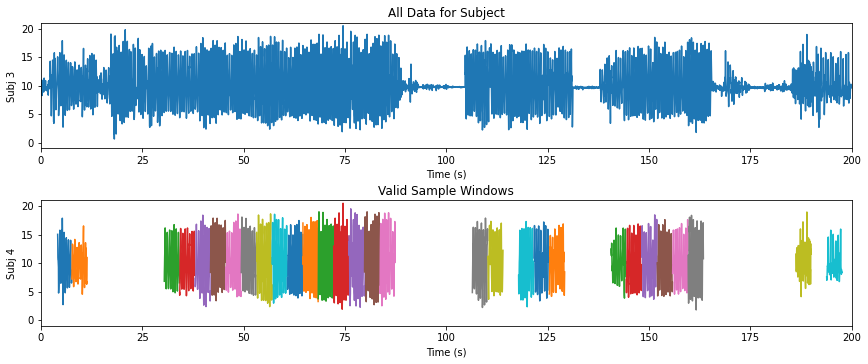

In [130]:
i_subj = 3
df = per_user_all_data[i_subj]
valid_windows = AccelUtils.extract_valid_time_windows_for_subj(df, WINDOW_SIZE_SEC, MAX_TIME_STEP)
    
fig,axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].plot(per_user_all_data[i_subj]['t'], per_user_all_data[i_subj]['mag_acc'])
axs[0].set_xlim(0, 200)
axs[0].set_ylim(-1, 21)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel(f'Subj {i+1}')
axs[0].set_title('All Data for Subject')

for win in valid_windows:
    axs[1].plot(win['t'], win['mag_acc'])
    axs[1].set_xlim(0, 200)
    axs[1].set_ylim(-1, 21)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel(f'Subj {i_subj+1}')
axs[1].set_title('Valid Sample Windows')
fig.tight_layout(pad=0.5)
print('Show which time-windows are considered valid by the specified criteria')
fig.savefig(f'example_valid_windows_subj_{i_subj}.png')

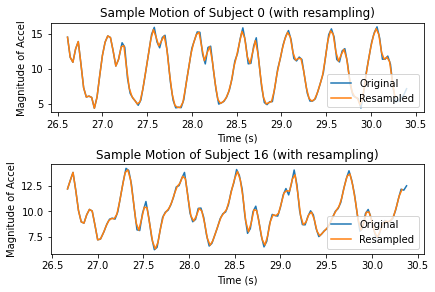

In [137]:
fig,axs = plt.subplots(2, 1, figsize=(6,4))
for p,i_subj in enumerate([0, 16]):
    df = per_user_all_data[i_subj]
    
    valid_windows = AccelUtils.extract_valid_time_windows_for_subj(df, WINDOW_SIZE_SEC, MAX_TIME_STEP)
    ts, mags = AccelUtils.resample_and_truncate(valid_windows[2], RESAMPLE_TIME_STEP, MAX_RESAMPLE_PTS)
    
    axs[p].plot(valid_windows[2]['t'], valid_windows[2]['mag_acc'])
    axs[p].plot(ts, mags)
    axs[p].set_xlabel('Time (s)')
    axs[p].set_ylabel('Magnitude of Accel')
    axs[p].set_title(f'Sample Motion of Subject {i_subj} (with resampling)')
    axs[p].legend(['Original', 'Resampled'], loc='lower right')

fig.tight_layout(pad=0.5)

In [121]:
def plot_samples_for_subj(window_list):
    fig, ax = plt.subplots()
    max_power = 0
    fpeaks_disp = []
    powers_disp = []
    for i in range(3):
        fs, pxx, sample_fpeaks, sample_powers = AccelUtils.compute_periodogram_with_peaks(
            window_list[i],
            RESAMPLE_TIME_STEP,
            MAX_RESAMPLE_PTS,
            max_peaks=3)

        ax.plot(fs, pxx)
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Sqrt(Spectral Power)')
        ax.set_title('Power spectrum of 3 samples from same subject')
        fpeaks_disp.append(', '.join([f'{f:.2f}' for f in sample_fpeaks]))
        powers_disp.append(', '.join([f'{p:.2f}' for p in sample_powers]))

    for f in sample_fpeaks:
        ax.plot([f, f], [0, 3], 'b-.', lw=0.5)
        
    for i in range(3):
        print(f'Top three dominant frequences for subj {i_subj}, sample {i}: {fpeaks_disp[i]}')
        
    print()
    for i in range(3):
        print(f'Power of three dominant freqs for subj {i_subj}, sample {i}: {powers_disp[i]}')

    return fig, ax

Top three dominant frequences for subj 16, sample 0: 4.07, 5.42, 5.96
Top three dominant frequences for subj 16, sample 1: 1.63, 3.25, 4.88
Top three dominant frequences for subj 16, sample 2: 1.63, 3.25, 4.88

Power of three dominant freqs for subj 16, sample 0: 0.31, 0.38, 0.31
Power of three dominant freqs for subj 16, sample 1: 0.55, 0.23, 0.22
Power of three dominant freqs for subj 16, sample 2: 0.58, 0.17, 0.25


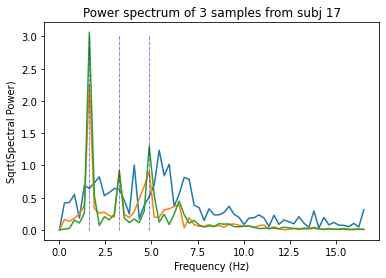

In [122]:
        
i_subj = 16
another_subj_windows = AccelUtils.extract_valid_time_windows_for_subj(
    per_user_all_data[i_subj],
    WINDOW_SIZE_SEC,
    MAX_TIME_STEP)

fig, ax = plot_samples_for_subj(another_subj_windows)
_ = ax.set_title(f'Power spectrum of 3 samples from subj {i_subj+1}')


Top three dominant frequences for subj 2, sample 0: 1.63, 3.25, 4.88
Top three dominant frequences for subj 2, sample 1: 1.63, 5.15, 6.78
Top three dominant frequences for subj 2, sample 2: 1.63, 5.15, 6.78

Power of three dominant freqs for subj 2, sample 0: 0.64, 0.16, 0.20
Power of three dominant freqs for subj 2, sample 1: 0.58, 0.21, 0.21
Power of three dominant freqs for subj 2, sample 2: 0.65, 0.18, 0.16


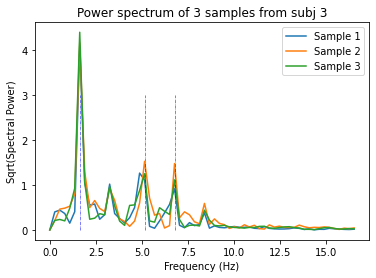

In [139]:
i_subj = 2
another_subj_windows = AccelUtils.extract_valid_time_windows_for_subj(
    per_user_all_data[i_subj],
    WINDOW_SIZE_SEC,
    MAX_TIME_STEP)

fig, ax = plot_samples_for_subj(another_subj_windows)
ax.legend(['Sample 1', 'Sample 2', 'Sample 3'])
_ = ax.set_title(f'Power spectrum of 3 samples from subj {i_subj+1}')

fig.savefig('sample_spectral_density.png')

Top three dominant frequences for subj 20, sample 0: 1.63, 3.79, 4.88
Top three dominant frequences for subj 20, sample 1: 1.63, 3.25, 4.88
Top three dominant frequences for subj 20, sample 2: 1.63, 3.52, 5.15

Power of three dominant freqs for subj 20, sample 0: 0.54, 0.16, 0.30
Power of three dominant freqs for subj 20, sample 1: 0.48, 0.22, 0.30
Power of three dominant freqs for subj 20, sample 2: 0.50, 0.24, 0.26


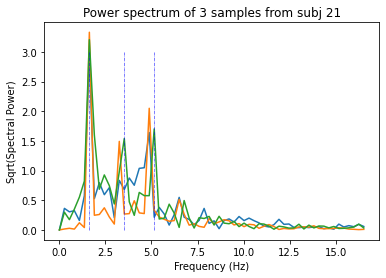

In [124]:
i_subj = 20
another_subj_windows = AccelUtils.extract_valid_time_windows_for_subj(
    per_user_all_data[i_subj],
    WINDOW_SIZE_SEC,
    MAX_TIME_STEP)

fig, ax = plot_samples_for_subj(another_subj_windows)
_ = ax.set_title(f'Power spectrum of 3 samples from subj {i_subj+1}')

